In [1]:
%load_ext autoreload
%autoreload 2

import batman
import gpjax as gpx
import jax.numpy as jnp
from jax import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from gpjax.kernels import RBF, Constant, Linear, Periodic, PoweredExponential

from kernels import OrnsteinUhlenbeck, ProductKernel, SumKernel
from kernelsearch import KernelSearch

import emcee

rng = np.random.default_rng(seed=42)

In [2]:
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
def calculate_lightcurve(t, params):
    param_container = batman.TransitParams()
    param_container.t0 = params[0]  # time of inferior conjunction
    param_container.per = 1.0  # orbital period
    param_container.rp = params[1]  # planet radius (in units of stellar radii)
    param_container.a = params[2]  # semi-major axis (in units of stellar radii)
    param_container.inc = 87.0  # orbital inclination (in degrees)
    param_container.ecc = 0.0  # eccentricity
    param_container.w = 90.0  # longitude of periastron (in degrees)
    param_container.u = [params[3], params[4]]  # limb darkening coefficients [u1, u2]
    param_container.limb_dark = "quadratic"  # limb darkening model

    m = batman.TransitModel(param_container, t)  # initializes model
    return m.light_curve(param_container)

In [4]:
t = np.linspace(-0.05, 0.08, 1000)
true_lightcurve = calculate_lightcurve(
    t=t,
    params=[0, 0.1, 15, 0.1, 0.3],
)

In [5]:
test_ind = np.sort(rng.choice(len(t), 150))
t_train = t[test_ind]
lc_latent = (
    true_lightcurve
    - 0.05 * np.cos(200 * t / (2 * np.pi))
    + 0.08 * ((t / t[-1]) ** 2 - 0.03) * np.sin(4000 * t / (2 * np.pi))
)
lc_train = lc_latent[test_ind]  # + rng.normal(scale=0.005, size=len(test_ind))

In [6]:
mask = ~np.ma.masked_where((-0.01 < t_train) & (t_train < 0.01), t_train).mask

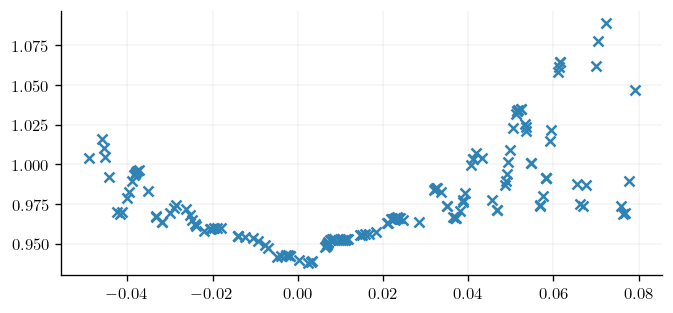

In [7]:
# plt.plot(t, true_lightcurve)
plt.scatter(t_train, lc_train)

In [8]:
from kernelsearch import KernelSearch
from kernels import OrnsteinUhlenbeck
from gpjax.kernels import RBF, Linear, Periodic, PoweredExponential

In [9]:
kernel_library = [
    Linear(),
    RBF(),
    OrnsteinUhlenbeck(),
    Periodic(),
    # PoweredExponential(power=jnp.array(0.5)),
]  # default powered exponential has infinite parameter for some reason

In [10]:
tree = KernelSearch(
    kernel_library,
    X=jnp.array(t_train[mask]),
    y=jnp.array(lc_train[mask]),
    obs_stddev=0.005,
    verbosity=1,
)

model = tree.search(
    depth=7,
    n_leafs=3,
    patience=1,
)

Fitting Layer 1: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]


Layer 1 || Current AICs: [-764.1620396517079, 936.508616268092, 937.2612913505425, 3666082.4380188417]


Fitting Layer 2:  62%|██████▎   | 15/24 [00:26<00:18,  2.04s/it]

In [ ]:
tree._kernel_name(model.prior.kernel)

'(RBF * Linear * Linear) + (RBF * Periodic)'

In [ ]:
latent_dist = model.predict(t.reshape(-1, 1), train_data=tree.data)
predictive_dist = model.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

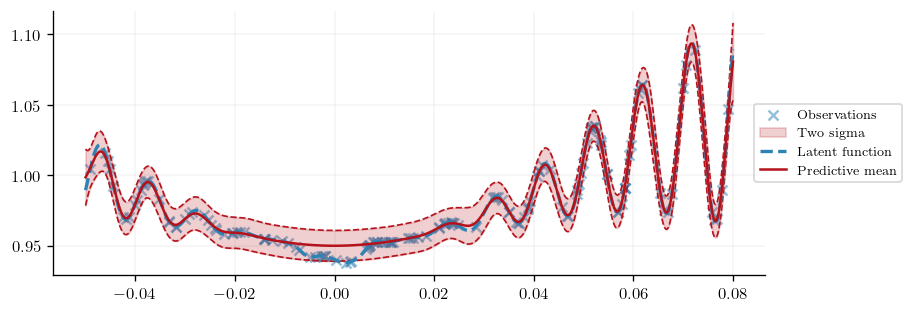

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.scatter(t_train, lc_train, label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    t,
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    t,
    lc_latent,
    label="Latent function",
    color=cols[0],
    linestyle="--",
    linewidth=2,
)
ax.plot(t, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))